In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import MinMaxScaler
import os

In [27]:
# Dataset
df=pd.read_csv('./../../dataset/raw_jawa_timur.csv', parse_dates=["date"], index_col="date")
#df['daily_case'] = df['daily_case'].str.replace(',','').astype(int)

# Cut dataset to start from 1 April 2022
df = df[14:]
df.head()

,daily_case
date,
2020-04-01,9
2020-04-02,0
2020-04-03,47
2020-04-04,5
2020-04-05,35


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 766 entries, 2020-04-01 to 2022-05-06
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   daily_case  766 non-null    int64
dtypes: int64(1)
memory usage: 12.0 KB


In [4]:
df.shape

(766, 1)

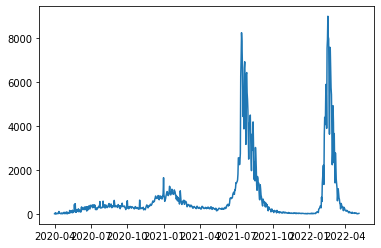

In [5]:
plt.plot(df)

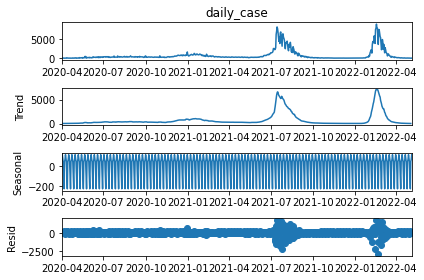

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['daily_case'])
results.plot();

In [7]:
df.shape

(766, 1)

In [8]:
# stationarity check
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [9]:
adf_test(df['daily_case'])

1. ADF :  -4.316334828855924
2. P-Value :  0.00041615249644473676
3. Num Of Lags :  16
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 749
5. Critical Values :
	 1% :  -3.439110818166223
	 5% :  -2.8654065210185795
	 10% :  -2.568828945705979


In [10]:
# Split data to train and test
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[:train_size]
test_data=df[train_size:]

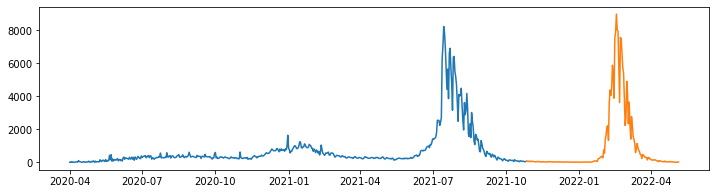

In [11]:
train_data=df[:train_size]
test_data=df[train_size:]
plt.figure(figsize=(12, 3))
plt.plot(train_data)
plt.plot(test_data)

In [12]:
from statsmodels.tsa.stattools import adfuller
#Ho: non stationary (ADF value <= 0.05)
#H1: stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [13]:
adfuller_test(df['daily_case'])

ADF Test Statistic : -4.316334828855924
p-value : 0.00041615249644473676
#Lags Used : 16
Number of Observations Used : 749
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [21]:
from pmdarima.arima import auto_arima
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=30,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=8359.644, Time=3.15 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=8376.816, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8376.033, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=8375.442, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=8374.817, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=8357.655, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=8359.880, Time=0.93 sec
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=8361.881, Time=2.24 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=8373.448, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=8374.041, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=8357.107, Time=0.26 sec
 ARIMA(2,1,1)(1,0,0)[30] intercept   : AIC=8359.039, Time=3.02 sec
 ARIMA(2,1,1)(0,0,1)[30] intercept   : AIC=8359.163, Time=2.23 sec
 ARIMA(2,1,1)(1,0,1)[30] intercept   : AIC=8361.163, Time=2.65 sec
 ARIMA(2,1,0)(0,0,0

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:               SARIMAX(6, 1, 6)   Log Likelihood               -4084.223
Date:                Sun, 29 May 2022   AIC                           8194.446
Time:                        14:14:15   BIC                           8251.008
Sample:                             0   HQIC                          8216.510
                                - 574                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9537      0.029    -32.928      0.000      -1.010      -0.897
ar.L2         -0.9316      0.039    -23.887      0.000      -1.008      -0.855
ar.L3         -0.9256      0.031    -29.961      0.000      -0.986      -0.865
ar.L4         -0.9146      0.042    -21.952      0.000      -0.996      -0.833
ar.L5         -0.9122      0.045    -20.220      0.000      -1.001      -0.824
ar.L6         -0.8325      0.037    -22.547      0.000      -0.905      -0.760
ma.L1          0.8691      0.039     22.485      0.000       0.793       0.945
ma.L2          0.8478      0.051     16.787      0.000       0.749       0.947
ma.L3          0.8426      0.049     17.350      0.000       0.747       0.938
ma.L4          0.6807      0.059     11.446      0.000       0.564       0.797
ma.L5          0.6660      0.055     12.011      0.000       0.557       0.775
ma.L6          0.4963      0.051      9.736      0.000       0.396       0.596
sigma2      9.807e+04   1360.927     72.062      0.000    9.54e+04    1.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             61396.59
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              24.20   Skew:                             2.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
model

ARIMA(order=(6, 1, 6), scoring_args={}, seasonal_order=(0, 0, 0, 30),
      suppress_warnings=True, with_intercept=False)

In [28]:
# Split data to train and test
df = df.values
df = df.astype('float32')
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[0:train_size]
test_data=df[train_size:len(df)]

history = [x for x in train_data]
predictions = []

In [29]:
train_size

574

In [30]:
predictions

[]

In [31]:
from statsmodels.tsa.arima.model import ARIMA
# walk-forward validation
for t in range(len(test_data)):
	model = ARIMA(history, order=(6,1,6), seasonal_order=(0,0,0,30))
	model_fit = model.fit()
	output = model_fit.forecast(steps=1)
	yhat = output[0]
	predictions.append(yhat)
	obs = test_data[t]
	history.append(obs) #append real observation to history
	print('predicted=%f, expected=%f' % (yhat, obs))
    
    

C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=48.282944, expected=90.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=67.773902, expected=72.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=66.195510, expected=54.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=64.902119, expected=81.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=55.296164, expected=57.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=53.807274, expected=40.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=73.960367, expected=74.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=83.691236, expected=67.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=50.011103, expected=59.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=54.210749, expected=46.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=58.637898, expected=47.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=32.269450, expected=32.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=28.076077, expected=30.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=57.248535, expected=49.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=47.575805, expected=65.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=53.698798, expected=42.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=35.737657, expected=33.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=38.322161, expected=49.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=35.452380, expected=30.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=29.548656, expected=26.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=44.706388, expected=35.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=41.283292, expected=43.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=30.033205, expected=24.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=19.025032, expected=28.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=36.789851, expected=30.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=17.176496, expected=25.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=26.989096, expected=21.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=34.531666, expected=45.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=51.460177, expected=36.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=22.063122, expected=32.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=31.234952, expected=48.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=48.500506, expected=31.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=26.843256, expected=33.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=29.632128, expected=10.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=24.500547, expected=36.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=36.535577, expected=30.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=19.552657, expected=36.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=44.267354, expected=22.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=16.189231, expected=27.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=26.984082, expected=29.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=17.145335, expected=18.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=38.029499, expected=36.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=32.132281, expected=27.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=26.991082, expected=30.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=27.008356, expected=20.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=19.747734, expected=22.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=22.453393, expected=22.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=13.722262, expected=14.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=30.405386, expected=27.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=22.194549, expected=28.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=28.986188, expected=25.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=19.624298, expected=23.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=23.446374, expected=20.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=19.089267, expected=22.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=17.744478, expected=15.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=25.718542, expected=14.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=14.393361, expected=9.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=8.235485, expected=17.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=13.821181, expected=25.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=24.707447, expected=11.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=12.647952, expected=5.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=0.891355, expected=9.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=11.883497, expected=24.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=23.057128, expected=16.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=18.834993, expected=19.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=20.488451, expected=18.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=12.778849, expected=15.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=13.456836, expected=8.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=7.084723, expected=10.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=17.250655, expected=17.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=13.528855, expected=12.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=15.869051, expected=25.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=23.769563, expected=15.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=12.587103, expected=29.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=24.259070, expected=16.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=15.814444, expected=8.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=15.471933, expected=29.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=21.770518, expected=18.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=26.391810, expected=22.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=18.065803, expected=21.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=22.631654, expected=23.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=17.234045, expected=26.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=22.515806, expected=14.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=24.711198, expected=44.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=36.826193, expected=50.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=52.823790, expected=89.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=85.126997, expected=92.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=88.613341, expected=79.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=75.968727, expected=69.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=57.147162, expected=60.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=70.675405, expected=213.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=197.922439, expected=238.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=248.123921, expected=255.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=252.543491, expected=318.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=286.490147, expected=363.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=341.942653, expected=359.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=333.675038, expected=276.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=322.027886, expected=759.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=714.805660, expected=563.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=572.912291, expected=1395.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1339.340427, expected=1681.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1602.671523, expected=2155.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=2125.144789, expected=2218.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=2011.056744, expected=1339.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1516.494215, expected=3610.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=3114.267003, expected=4385.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4474.660325, expected=4054.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4160.692379, expected=4506.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4307.120337, expected=5880.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=5628.435626, expected=5376.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4440.251191, expected=3885.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4584.433597, expected=7530.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=7186.208938, expected=7919.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=7201.937881, expected=8977.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=9247.622498, expected=8037.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=8301.796517, expected=7946.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=7621.882213, expected=5766.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4637.305304, expected=3621.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=5305.059973, expected=7569.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=7302.838886, expected=7486.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=8120.004619, expected=6643.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=6652.781510, expected=5729.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=6115.462723, expected=5413.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4165.934368, expected=3861.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=2637.100629, expected=2233.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=5315.703076, expected=2761.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=3262.783491, expected=4911.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4833.660657, expected=4135.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=3656.055616, expected=2331.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=3063.066814, expected=3651.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=2357.970744, expected=2325.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1410.247003, expected=1410.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=2506.301927, expected=2769.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4514.698260, expected=2246.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=2027.966331, expected=1575.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=761.364598, expected=1394.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=2103.663132, expected=1165.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=581.582520, expected=596.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=80.878959, expected=838.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1935.208531, expected=1140.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=1735.843729, expected=904.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=584.609755, expected=725.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=404.649560, expected=661.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=700.737228, expected=470.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=125.850927, expected=452.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=627.586531, expected=228.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=697.047975, expected=478.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=694.420114, expected=440.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=165.357037, expected=368.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=304.308515, expected=303.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=196.580490, expected=310.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=313.663200, expected=277.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=227.503339, expected=148.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=458.860746, expected=307.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=327.299578, expected=240.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=156.632011, expected=255.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=157.463383, expected=177.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=186.715450, expected=158.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=163.399622, expected=140.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=113.010005, expected=124.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=280.729912, expected=165.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=151.933127, expected=153.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=143.388493, expected=143.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=61.011782, expected=121.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=143.475794, expected=86.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=72.438456, expected=81.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=110.347292, expected=48.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=92.583864, expected=106.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=120.596919, expected=85.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=56.012445, expected=69.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=57.274367, expected=54.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=40.636638, expected=46.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=55.746056, expected=55.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=50.174219, expected=31.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=76.235432, expected=79.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=73.797739, expected=41.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=28.131764, expected=32.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=22.158188, expected=40.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=33.515430, expected=40.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=48.161623, expected=33.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=29.120886, expected=25.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=60.049620, expected=55.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=35.917530, expected=32.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=25.132088, expected=27.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=23.378734, expected=40.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=43.872635, expected=17.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=15.083478, expected=22.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=26.271126, expected=9.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=25.836159, expected=8.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=2.394157, expected=14.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=6.655412, expected=18.000000
predicted=22.590799, expected=24.000000


C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [32]:
import math
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 556.310


In [33]:
train_data

array([[9.000e+00],
       [0.000e+00],
       [4.700e+01],
       [5.000e+00],
       [3.500e+01],
       [9.000e+00],
       [5.000e+00],
       [1.500e+01],
       [3.600e+01],
       [3.000e+01],
       [1.500e+01],
       [1.110e+02],
       [5.200e+01],
       [3.600e+01],
       [2.500e+01],
       [1.300e+01],
       [1.000e+01],
       [3.400e+01],
       [4.300e+01],
       [5.000e+00],
       [1.000e+01],
       [3.600e+01],
       [2.700e+01],
       [2.000e+01],
       [7.500e+01],
       [1.900e+01],
       [1.200e+01],
       [5.800e+01],
       [2.000e+01],
       [7.500e+01],
       [8.300e+01],
       [7.000e+00],
       [7.700e+01],
       [1.300e+01],
       [4.100e+01],
       [4.800e+01],
       [3.400e+01],
       [3.000e+01],
       [1.580e+02],
       [7.800e+01],
       [5.400e+01],
       [1.110e+02],
       [1.410e+02],
       [8.500e+01],
       [5.700e+01],
       [1.680e+02],
       [5.700e+01],
       [1.240e+02],
       [8.400e+01],
       [1.240e+02],


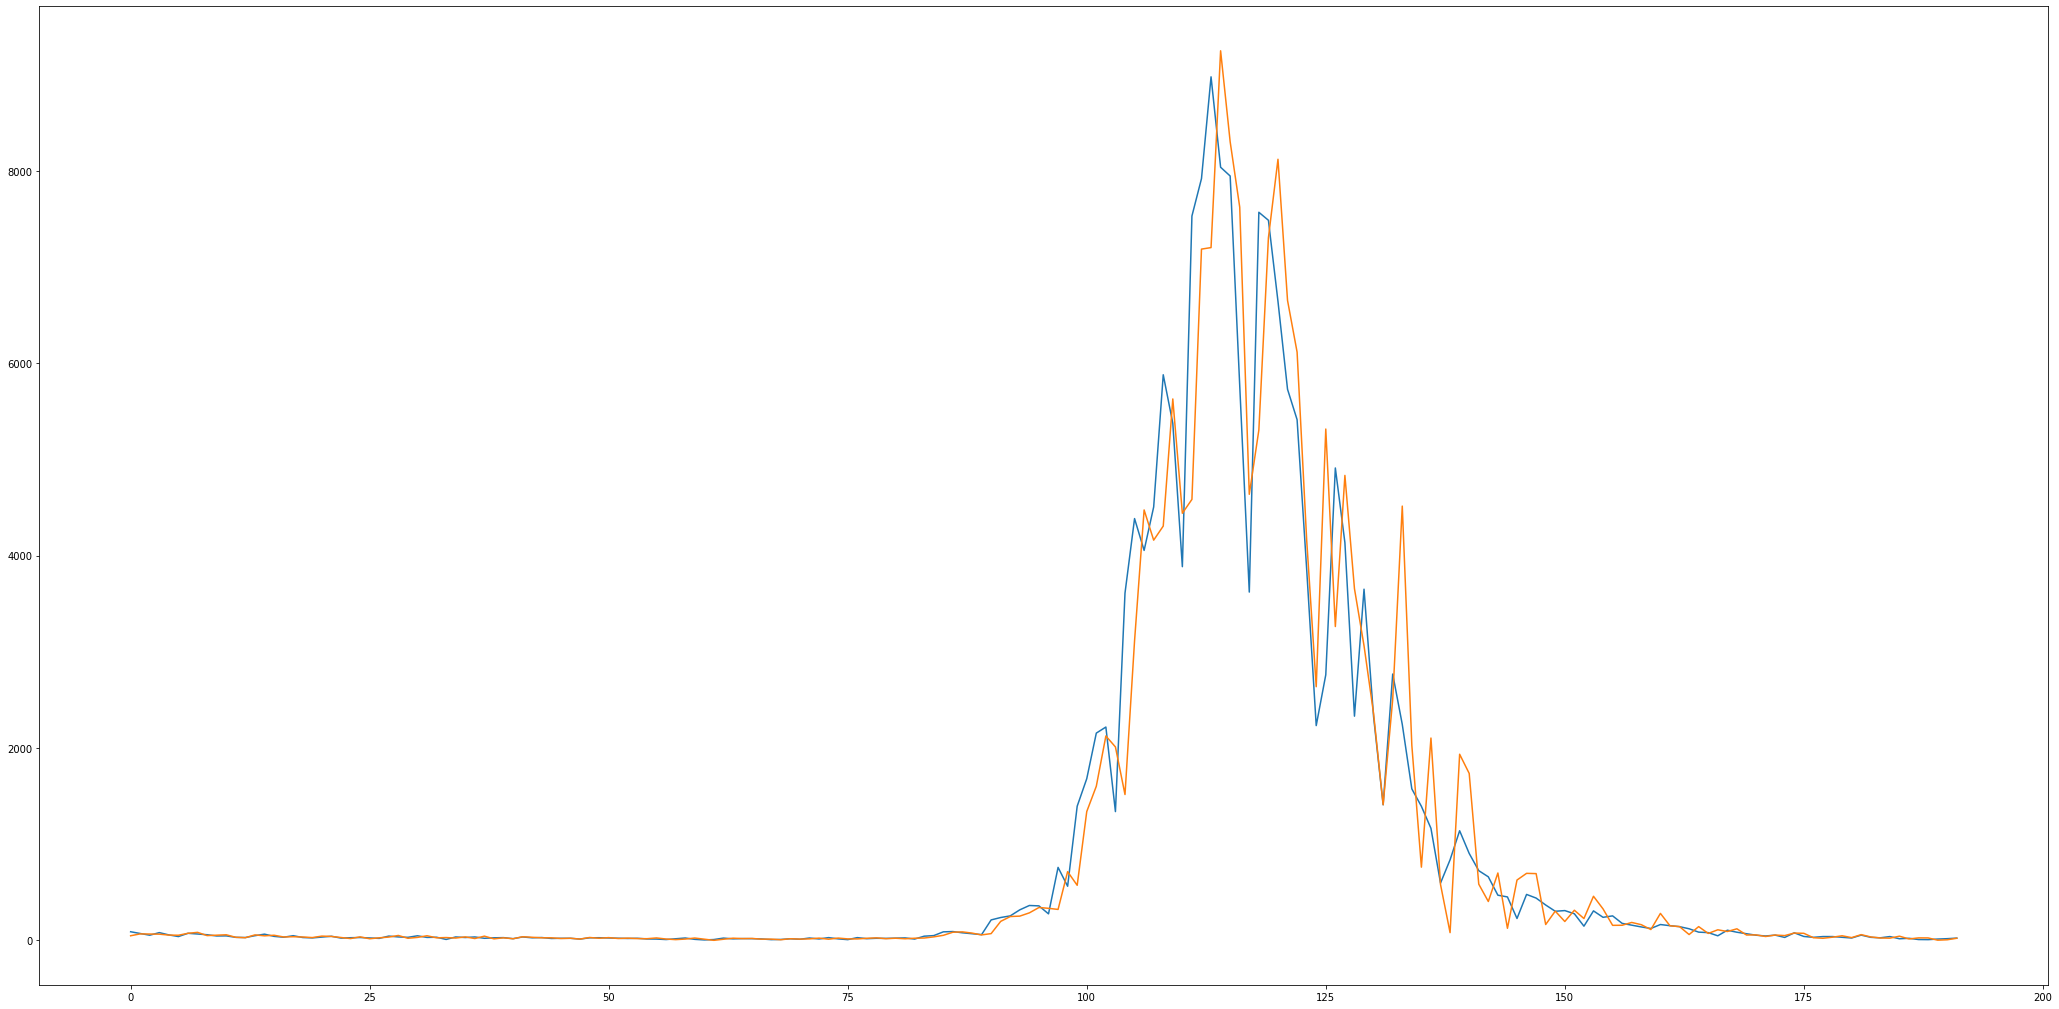

In [34]:
plt.figure(figsize=(36,18)) 
plt.plot(test_data)
plt.plot(predictions)

plt.show()

In [35]:
history

[array([9.], dtype=float32),
 array([0.], dtype=float32),
 array([47.], dtype=float32),
 array([5.], dtype=float32),
 array([35.], dtype=float32),
 array([9.], dtype=float32),
 array([5.], dtype=float32),
 array([15.], dtype=float32),
 array([36.], dtype=float32),
 array([30.], dtype=float32),
 array([15.], dtype=float32),
 array([111.], dtype=float32),
 array([52.], dtype=float32),
 array([36.], dtype=float32),
 array([25.], dtype=float32),
 array([13.], dtype=float32),
 array([10.], dtype=float32),
 array([34.], dtype=float32),
 array([43.], dtype=float32),
 array([5.], dtype=float32),
 array([10.], dtype=float32),
 array([36.], dtype=float32),
 array([27.], dtype=float32),
 array([20.], dtype=float32),
 array([75.], dtype=float32),
 array([19.], dtype=float32),
 array([12.], dtype=float32),
 array([58.], dtype=float32),
 array([20.], dtype=float32),
 array([75.], dtype=float32),
 array([83.], dtype=float32),
 array([7.], dtype=float32),
 array([77.], dtype=float32),
 array([13.], dt

In [36]:
model = ARIMA(history, order=(2,1,0), seasonal_order=(0,0,1,30))

model_fit = model.fit()
output = model_fit.forecast(steps=1)
# multi-step out-of-sample forecast
start_index = len(history)
end_index = start_index + 29
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in df]
day = 1
for yhat in forecast:
	print('Day %d: %f' % (day, yhat))
	history.append(yhat)
	day += 1

# forecast = model_fit.forecast(steps=30)

Day 1: 22.600075
Day 2: 22.048367
Day 3: 22.712956
Day 4: 22.856633
Day 5: 23.093867
Day 6: 22.632266
Day 7: 22.804175
Day 8: 22.919060
Day 9: 23.063815
Day 10: 23.143291
Day 11: 23.071005
Day 12: 23.289519
Day 13: 22.880847
Day 14: 23.222319
Day 15: 23.282375
Day 16: 23.218070
Day 17: 23.220867
Day 18: 23.285545
Day 19: 23.353984
Day 20: 23.100380
Day 21: 23.306733
Day 22: 23.338837
Day 23: 23.233568
Day 24: 23.428859
Day 25: 23.390455
Day 26: 23.503517
Day 27: 23.514517
Day 28: 23.463539
Day 29: 23.427156
Day 30: 23.377286


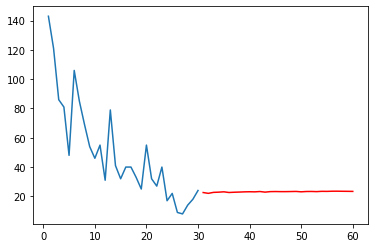

In [37]:
day_new=np.arange(1,31) # dari data 30 hari terakhir
day_pred=np.arange(31,61) #predict 30 hari kedepan

plt.plot(day_new, df[736:766])
plt.plot(day_pred, forecast, color='red')
plt.show()

C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


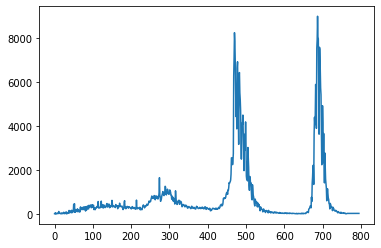

In [38]:
plt.plot(history)
plt.show()